### Feature Classifier 2022-03
The point of this file is to see how well a model can classify road segments given limited, proximal information from the cities centreline data.
Some of this data is already used for the classification of LTS; however, this model tries to use limited, easy to access datasets that may be transferrable across all cities in order to speed up the classification process without using all of the features used in the 2016 paper.

In [1]:
#Import all packages from model functions
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

Import train centreline data

In [2]:
train_data = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centreline_train.csv')
print(train_data.shape)
train_data.head()

(47642, 20)


,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,CENTRELINE_ID,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,LINEAR_NAME_FULL,geometry_y,high access
0,16991,16992,14661293,4471,St Patrick St,14041260,14121646,0,160.386984,14661293,2,0.001499,LINESTRING (629932.7238058376 4834347.23222766...,14661293.0,201400.0,Collector,CITY OF TORONTO,St Patrick St,LINESTRING (629932.7242540801 4834347.23280311...,1
1,28291,28292,438283,4074,Norton Ave,13446764,13446721,0,117.086314,438283,2,0.001430,LINESTRING (628657.7381234787 4848089.99042398...,438283.0,201500.0,Local,CITY OF TORONTO,Norton Ave,LINESTRING (628657.7375918713 4848089.99058160...,1
2,5549,5550,30040671,10882,Humber Bay Park Rd W,30040667,30040670,0,169.197741,30040671,1,0.001829,LINESTRING (622624.2632394056 4830686.75192849...,30040671.0,201803.0,Access Road,PRIVATE,Humber Bay Park Rd W,LINESTRING (622624.2636263596 4830686.75219677...,1
3,49491,49492,106234,11034,441 Military Trl,13444700,13444661,0,50.108924,106234,2,0.000540,LINESTRING (644269.5569116214 4849901.81035351...,106234.0,201600.0,Other,PRIVATE,441 Military Trl,LINESTRING (644269.5564427621 4849901.81021205...,1
4,28982,28983,30113436,4869,Ballyconnor Crt,30113434,30113431,0,126.066066,30113436,1,0.001423,LINESTRING (629780.5708327258 4850905.92105809...,30113436.0,201500.0,Local,CITY OF TORONTO,Ballyconnor Crt,LINESTRING (629780.5704534939 4850905.92094549...,1


#### Clean and feature engineer using model_functions.py

After evaluating the features in the model, many of them are similar. Ex. Arterial vs. Arterial Ramp. <br>
Before doing any other feature eng, create a function that combines these similar features. Convert to the majoy road types: <br>
Local, Collector, Arterial, Highway. Keep paths seperate. Do we lose info when we do this?

In [3]:
train_data['FEATURE_CODE_DESC'].unique()
def map_centreline_features(data):
    """
    Maps the centreline feature codes to their more like features.
    """
    data_m = data.copy()
    data_m['FEATURE_CODE_DESC'] = data_m['FEATURE_CODE_DESC'].replace({'Laneway':'Local',
                                                                       'Minor Arterial':'Arterial',
                                                                       'Major Arterial':'Arterial',
                                                                       'Major Arterial Ramp':'Arterial',
                                                                       'Walkway':'Trail',
                                                                       'Collector Ramp':'Collector',
                                                                       'Minor Arterial Ramp':'Arterial',
                                                                        })
    
    
    return data_m

train_data = map_centreline_features(train_data)
train_data['FEATURE_CODE_DESC']

0          Collector
1              Local
2        Access Road
3              Other
4              Local
            ...     
47637          Local
47638          Trail
47639          Local
47640          Local
47641      Collector
Name: FEATURE_CODE_DESC, Length: 47642, dtype: object

In [4]:
# Split features/target
y_train_lts = train_data['LTS']
y_train_access = train_data['high access']
X_train = train_data.drop(['LTS','high access'], axis=1)

In [5]:
# Engineer features usign model functions.
keep_rows = ['FEATURE_CODE_DESC','geometry']
X_train = droprows(X_train, keep_rows)
X_train = add_regions(X_train, 2, 3)
X_train = dummy(X_train, dummy_feats=['FEATURE_CODE_DESC','x_region','y_region'])
X_train.head()

Principal component 0
explains 74.28345579587307 % of the variance in "lon" and "lat".
Principal component 1
explains 25.716544204126933 % of the variance in "lon" and "lat".


,geometry,FEATURE_CODE_DESC_Arterial,FEATURE_CODE_DESC_Busway,FEATURE_CODE_DESC_Collector,FEATURE_CODE_DESC_Expressway Ramp,FEATURE_CODE_DESC_Local,FEATURE_CODE_DESC_Other,FEATURE_CODE_DESC_Other Ramp,FEATURE_CODE_DESC_Pending,FEATURE_CODE_DESC_Trail,x_region_2,x_region_3,y_region_2,y_region_3
0,"LINESTRING (629932.724 4834347.232, 629931.048...",0,0,1,0,0,0,0,0,0,1,0,0,0
1,"LINESTRING (628657.738 4848089.990, 628684.547...",0,0,0,0,1,0,0,0,0,0,1,0,1
2,"LINESTRING (622624.263 4830686.752, 622636.414...",0,0,0,0,0,0,0,0,0,0,0,0,0
3,"LINESTRING (644269.557 4849901.810, 644303.392...",0,0,0,0,0,1,0,0,0,0,1,1,0
4,"LINESTRING (629780.571 4850905.921, 629780.799...",0,0,0,0,1,0,0,0,0,0,1,0,1


In [6]:
X_train.shape

(47642, 14)

#### Feature Selection
Preprocessing and Cross Validation to choose the best features for the model

Define some models that we would like to test

In [7]:
model_log = LogisticRegression()
model_svm = svm.SVC()
model_rf = RandomForestClassifier()

Use the normal feature selector function to see CV results without spatial autocorrolation

In [8]:
feature_selector(model_log, splits=10, X=X_train.iloc[:,1:], y=y_train_access, i=10)

Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected fea

<br>Use the spatial cross validation function to get a better look at the feature performance

In [ ]:
spatial_cv(model_log, splits=10, X=X_train.iloc[:,1:], y=y_train_access)

Select Features

In [54]:
#features = ['FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Collector Ramp', 
#             'FEATURE_CODE_DESC_Laneway', 'FEATURE_CODE_DESC_Local', 
#             'FEATURE_CODE_DESC_Major Arterial', 'FEATURE_CODE_DESC_Major Arterial Ramp', 
#             'FEATURE_CODE_DESC_Minor Arterial', 'FEATURE_CODE_DESC_Other', 
#             'FEATURE_CODE_DESC_Trail', 'FEATURE_CODE_DESC_Walkway']

features = ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 
            'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Trail',
            'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']

#### Tune hyperparameters
use random search

In [63]:
cv = StratifiedKFold(n_splits=10)

# Choose hyper-params
params_log = {'penalty': ('l1', 'l2'),
              'fit_intercept': (True, False),
              'C': loguniform(1e-3, 1e2),
              'class_weight': ('balanced')
             }

# Do the search (might take awhile)
r_search_log = RandomizedSearchCV(estimator=model_log,
                                  param_distributions=params_log,
                                  n_iter=200,
                                  scoring='f1_weighted',
                                  cv=cv,
                                 )

r_search_log.fit(X_train[features], y_train_access)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_iter=200,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213802CAE20>,
                                        'class_weight': 'balanced',
                                        'fit_intercept': (True, False),
                                        'penalty': ('l1', 'l2')},
                   scoring='f1_weighted')

In [64]:
print('best weighted score', r_search_log.best_score_)
print('best estimator: ',r_search_log.best_estimator_)

best weighted score 0.9112234542739797
best estimator:  LogisticRegression(C=0.4281227100939832, class_weight='d')


<br>Train the model:

In [68]:
model_features = LogisticRegression(C=0.4281227100939832, class_weight='balanced')
model_features.fit(X_train[features], y_train_access)

y_pred = model_features.predict(X_train[features])

#See week 9 lec 3 slide 57 when choosing class balance

#### Model Evaluation
Metrics, visualizations included

In [69]:
print('accuracy: ', accuracy_score(y_train_access, y_pred))
print('weighted f1: ', f1_score(y_train_access, y_pred, average='weighted'))

accuracy:  0.8931824860417279
weighted f1:  0.8989414784682153


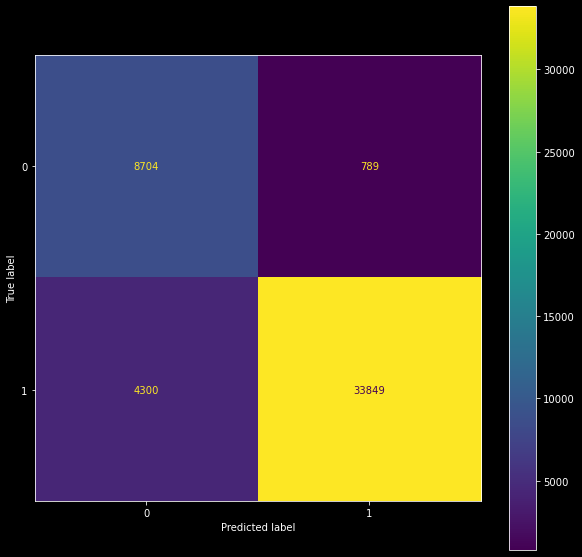

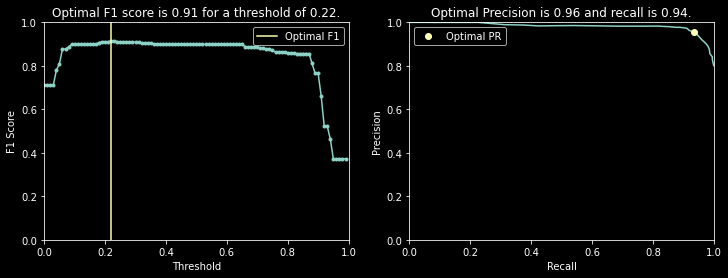

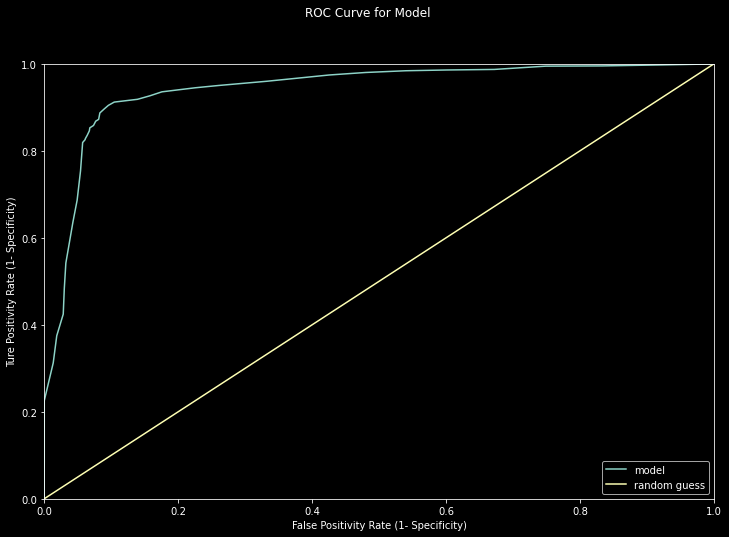

In [70]:
# Confusion matrix
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_features, X_train[features], y_train_access, ax=ax)
ax.grid(False)

#Weighted F1 score with optimal threshold if relevant
plot_f1_threshold(X_train[features], y_train_access, model_features)

#roc curve
plot_roc(y_train_access, model_features.predict_proba(X_train[features]))

Plot the classifications geospatially

In [71]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [72]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

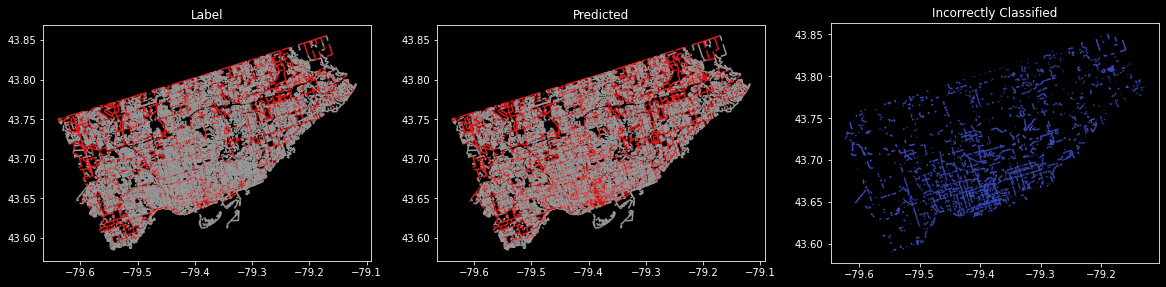

In [73]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['diff'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')

# Figure
fig, axs = plt.subplots(figsize=(20,12), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='Set1')
plotr.plot(ax=axs[1], column=0, cmap='Set1')
plotr[plotr['diff'] == 'incorrect'].plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

plt.show()